In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from pyinverse.axis import RegularAxis
from pyinverse.grid import RegularGrid
from pyinverse.rect import srect_2D_proj
from pyinverse.phantom import Phantom

In [3]:
#Nx = 32
#Ny = 40

#Nx = 129
#Ny = 129

Nx = 33
Ny = 33

t_max = 1
#t_max = 2
Np = 11
#Np = 3
Na = 45
#Na = 2

In [4]:
axis_x = RegularAxis.linspace(-1, 1, Nx)
axis_y = RegularAxis.linspace(-1, 1, Ny)
axis_t = RegularAxis.linspace(-t_max, t_max, Np)
axis_theta = RegularAxis.linspace(0, 180, Na, endpoint=False)

In [5]:
grid = RegularGrid(axis_x, axis_y)
grid_y = RegularGrid(axis_theta, axis_t)

In [6]:
grid

<RegularGrid <axis_x: <RegularAxis x0=-1 T=0.0625 N=33>> <axis_y: <RegularAxis x0=-1 T=0.0625 N=33>>>

In [7]:
H = np.zeros((Np*Na, Nx*Ny))

In [8]:
Tx = grid.axis_x.T
Ty = grid.axis_y.T

theta_rad = np.radians(grid_y.axis_x)

# CHANGE --- BUILD CSR MATRIX
for i in tqdm(range(Ny)):
    for j in range(Nx):
        center_y, center_x = grid[i, j]
        for k, theta_k in enumerate(theta_rad):
            t_prime = grid_y.axis_y.centers - center_x * np.cos(theta_k) - center_y * np.sin(theta_k)
            p_theta_k = srect_2D_proj([theta_k], t_prime, 1/Tx, 1/Ty)
            H[range(k, Na*Np, Na), i*Nx + j] = p_theta_k.flat

100%|█████████████████████████████████████████████████████████████████| 33/33 [00:02<00:00, 15.16it/s]


<IPython.core.display.Javascript object>


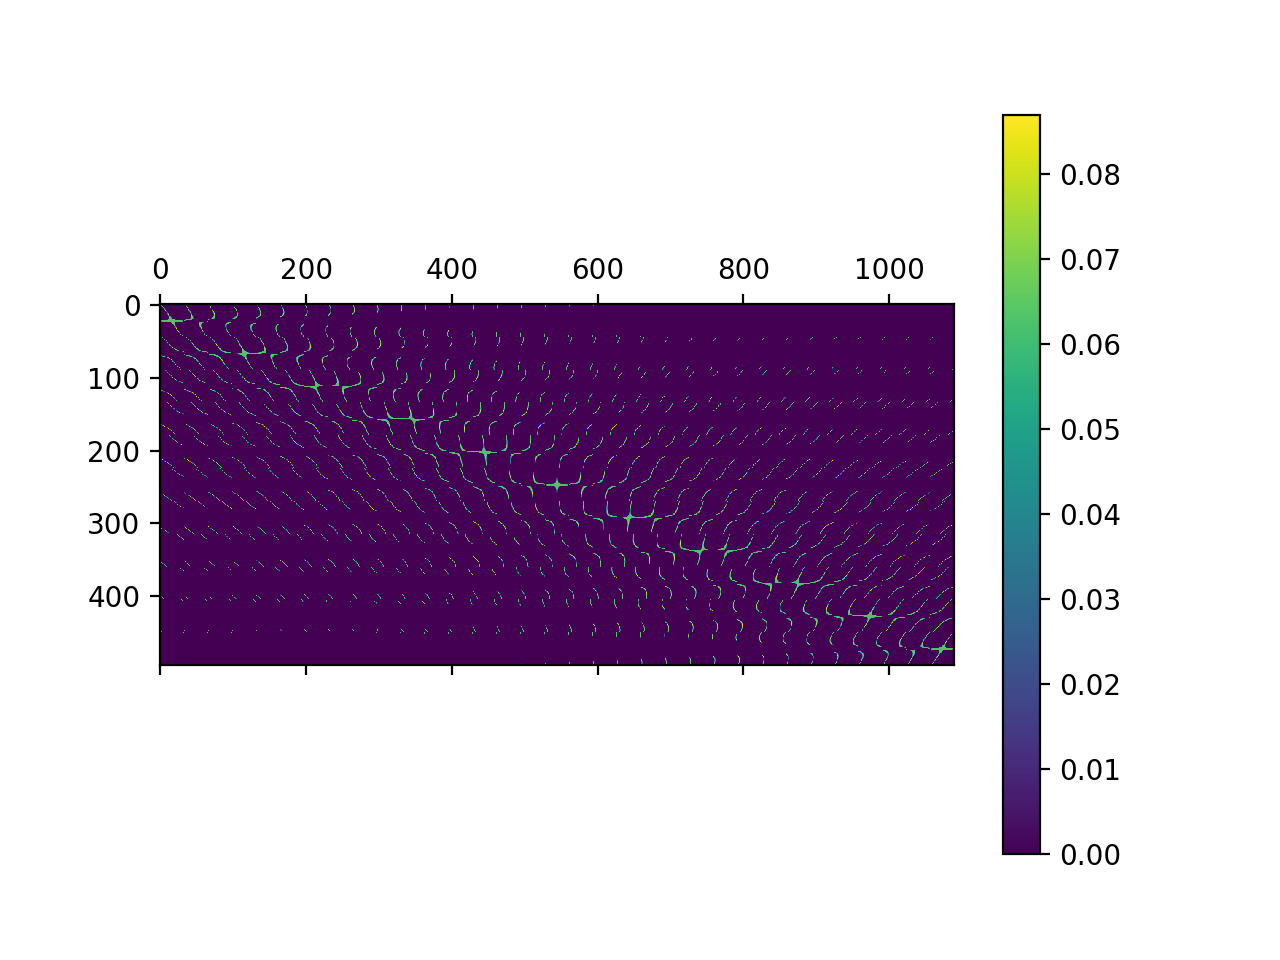

In [9]:
fig, ax = plt.subplots()
im = ax.matshow(H)
fig.colorbar(im);

In [10]:
p = Phantom()
x = p.raster(grid)

<IPython.core.display.Javascript object>


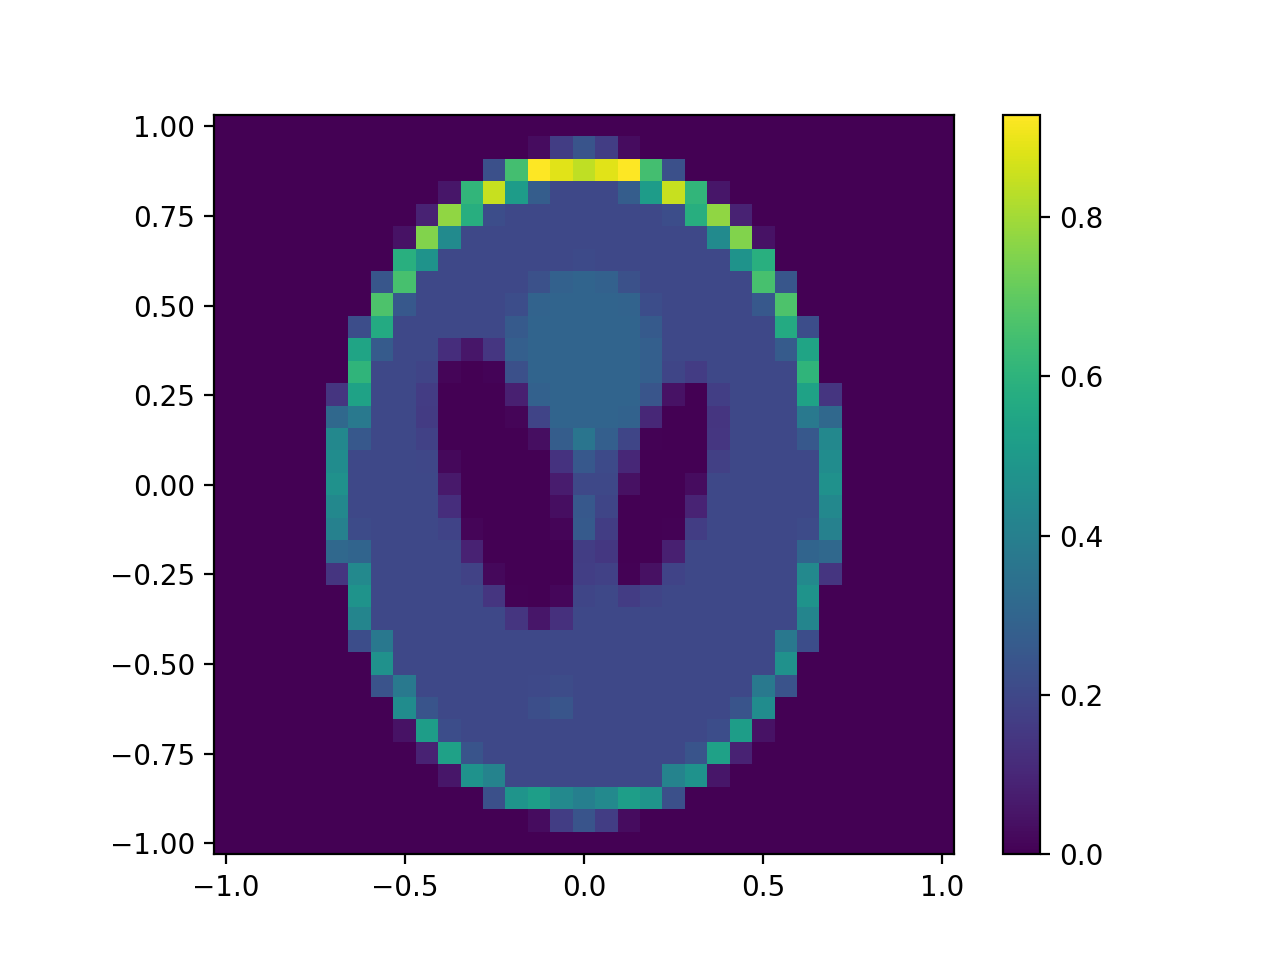

In [11]:
fig, ax = plt.subplots()
im = grid.plot(ax, x)
fig.colorbar(im);

In [12]:
y = p.sinogram(grid_y)

<IPython.core.display.Javascript object>


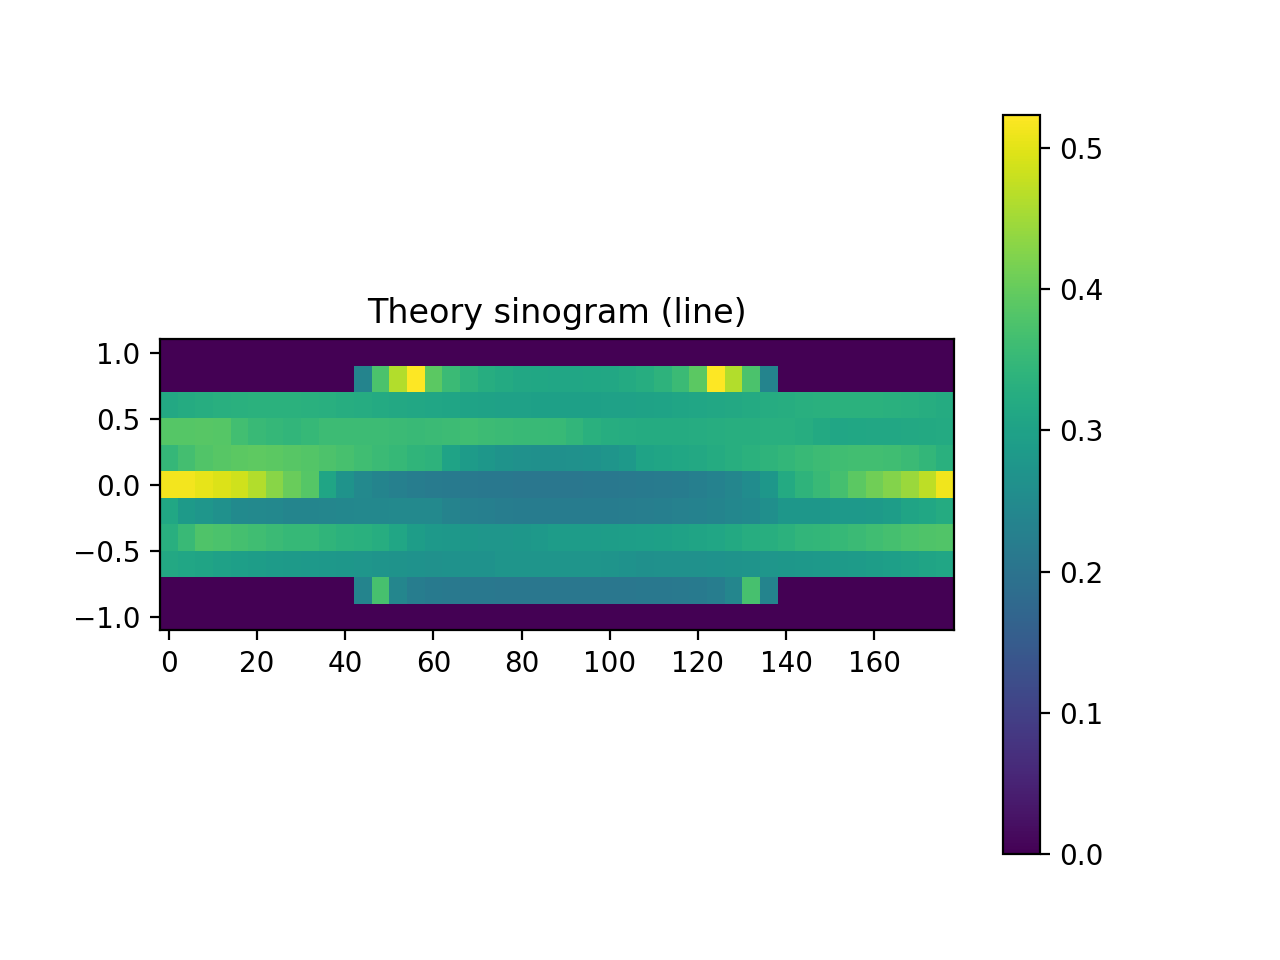

In [13]:
fig, ax = plt.subplots()
im = grid_y.plot(ax, y)
ax.set_aspect(30)
ax.set_title('Theory sinogram (line)')
fig.colorbar(im);

In [14]:
y_matrix = H @ x.flat
y_matrix.shape = Np, Na

<IPython.core.display.Javascript object>


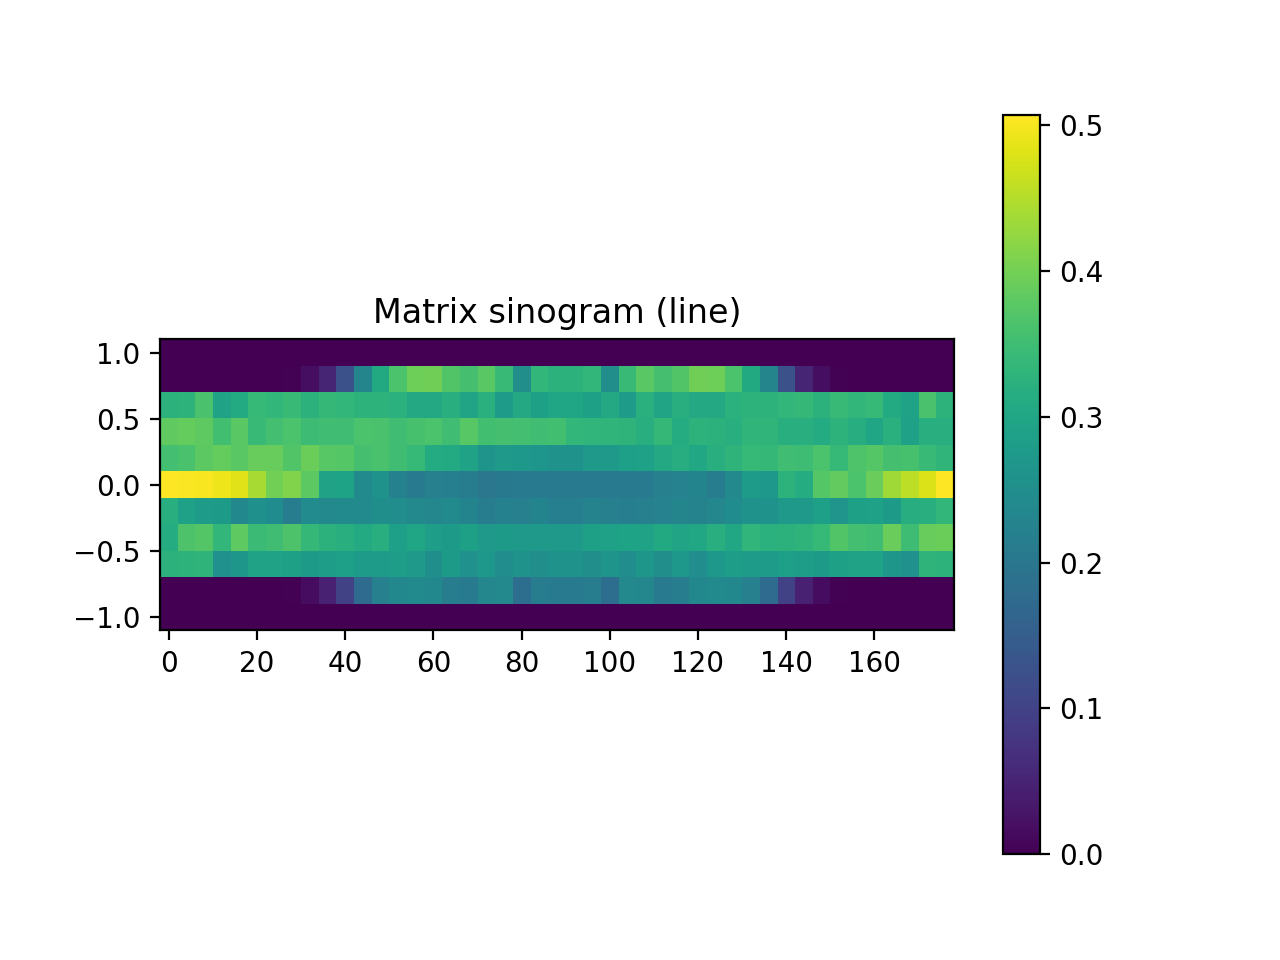

In [15]:
fig, ax = plt.subplots()
im = grid_y.plot(ax, y_matrix)
ax.set_aspect(30)
ax.set_title('Matrix sinogram (line)')
fig.colorbar(im);

In [16]:
def step(x):
    y = np.zeros_like(x)
    y[x > 0] = 1
    return y

In [17]:
def step1(x):
    y = np.zeros_like(x)
    y[x > 0] = x[x > 0]
    return y

In [18]:
def step2(x):
    y = np.zeros_like(x)
    y[x > 0] = 1/2 * x[x > 0]**2
    return y

In [19]:
def tri(x, b=1):
    assert b > 0
    return b*step1(x + 1/b) - 2*b*step1(x) + b*step1(x - 1/b)

<IPython.core.display.Javascript object>


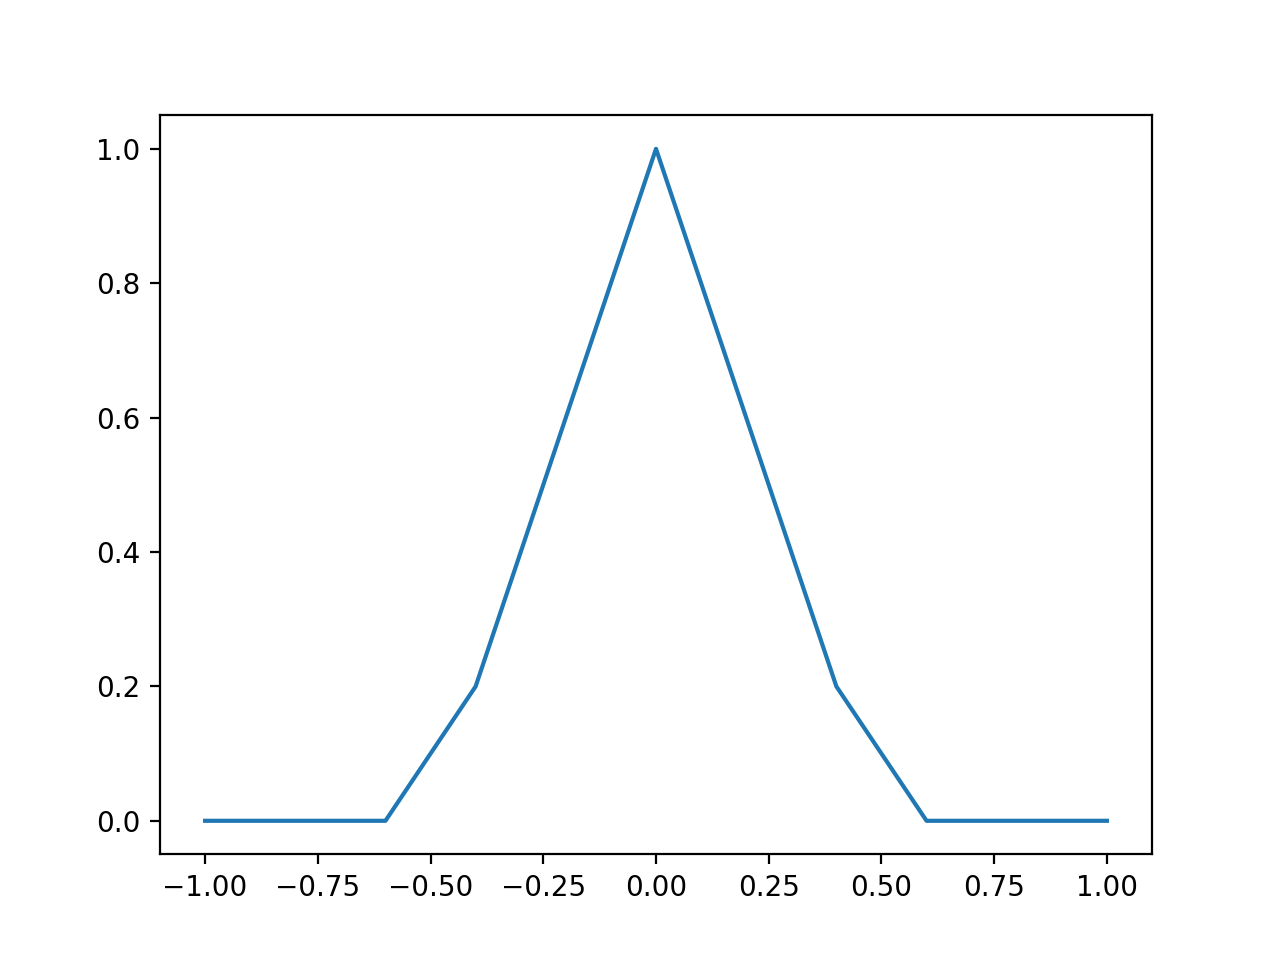

In [20]:
fig, ax = plt.subplots()
ax.plot(axis_t.centers, tri(axis_t.centers, 2));

\begin{align}
u(x) &= \begin{cases}
1 & x > 0 \\
0 & x \leq 0
\end{cases} \\
\text{rect}(ax) &= u(x+1/a) - u(x-1/a) \\
u_1(x) &= u(x) * u(x) = x\, u(x) \\
u_2(x) &= u(x) * u_1(x) = \frac{1}{2} x^2 u(x) 
\end{align}

In [21]:
def rtri(x, a, b):
    assert a > 0
    assert b > 0
    return b*(step2(x + 1/(2*a) + 1/b) - 2*step2(x + 1/(2*a)) + step2(x + 1/(2*a) - 1/b) - step2(x - 1/(2*a) + 1/b) + 2*step2(x - 1/(2*a)) - step2(x - 1/(2*a) - 1/b))

<IPython.core.display.Javascript object>


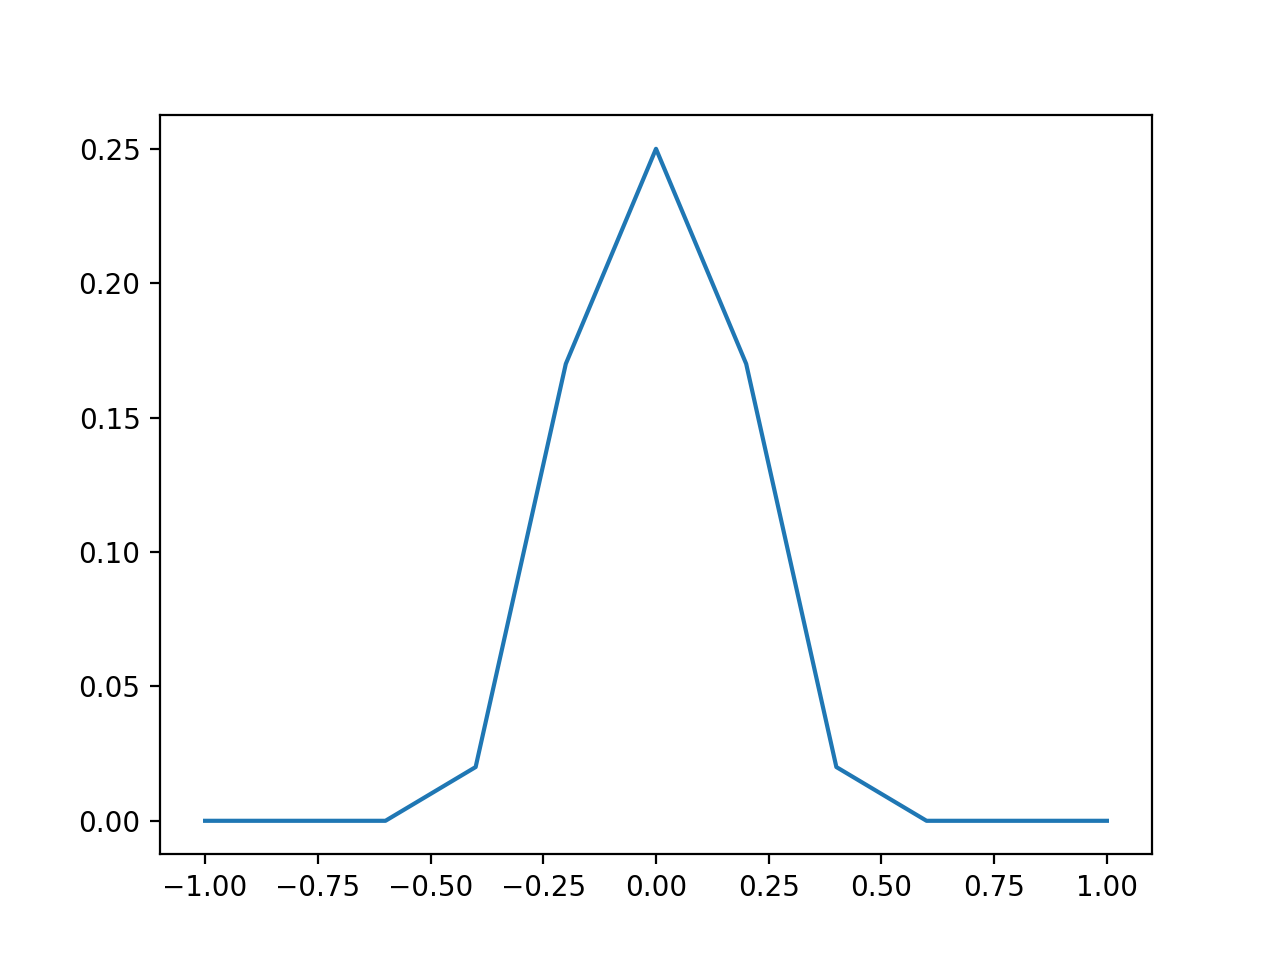

In [22]:
fig, ax = plt.subplots()
ax.plot(axis_t.centers, rtri(axis_t.centers, 2, 4));

In [23]:
def rect(t):
    """Rectangle function."""
    f = np.zeros_like(t)
    I = np.abs(t) < 0.5
    f[I] = 1
    f[np.abs(t) == 0.5] = 0.5
    return f

In [24]:
def square_proj(theta, r):
    theta = theta % (2*np.pi)
    if theta in [np.pi/4, 3*np.pi/4, 5*np.pi/4, 7*np.pi/4]:
        return np.sqrt(2) * tri(r/(np.sqrt(2)/2))
    elif np.abs(theta) in [0, np.pi/2, np.pi, 3*np.pi/2]:
        return rect(r)
    else:
        d_max = (np.abs(np.cos(theta)) + np.abs(np.sin(theta))) / 2
        d_break = np.abs(np.abs(np.cos(theta)) - np.abs(np.sin(theta))) / 2
        return 1/np.abs(np.cos(theta)*np.sin(theta)) * (d_max*tri(r/d_max) - d_break*tri(r/d_break))

<IPython.core.display.Javascript object>


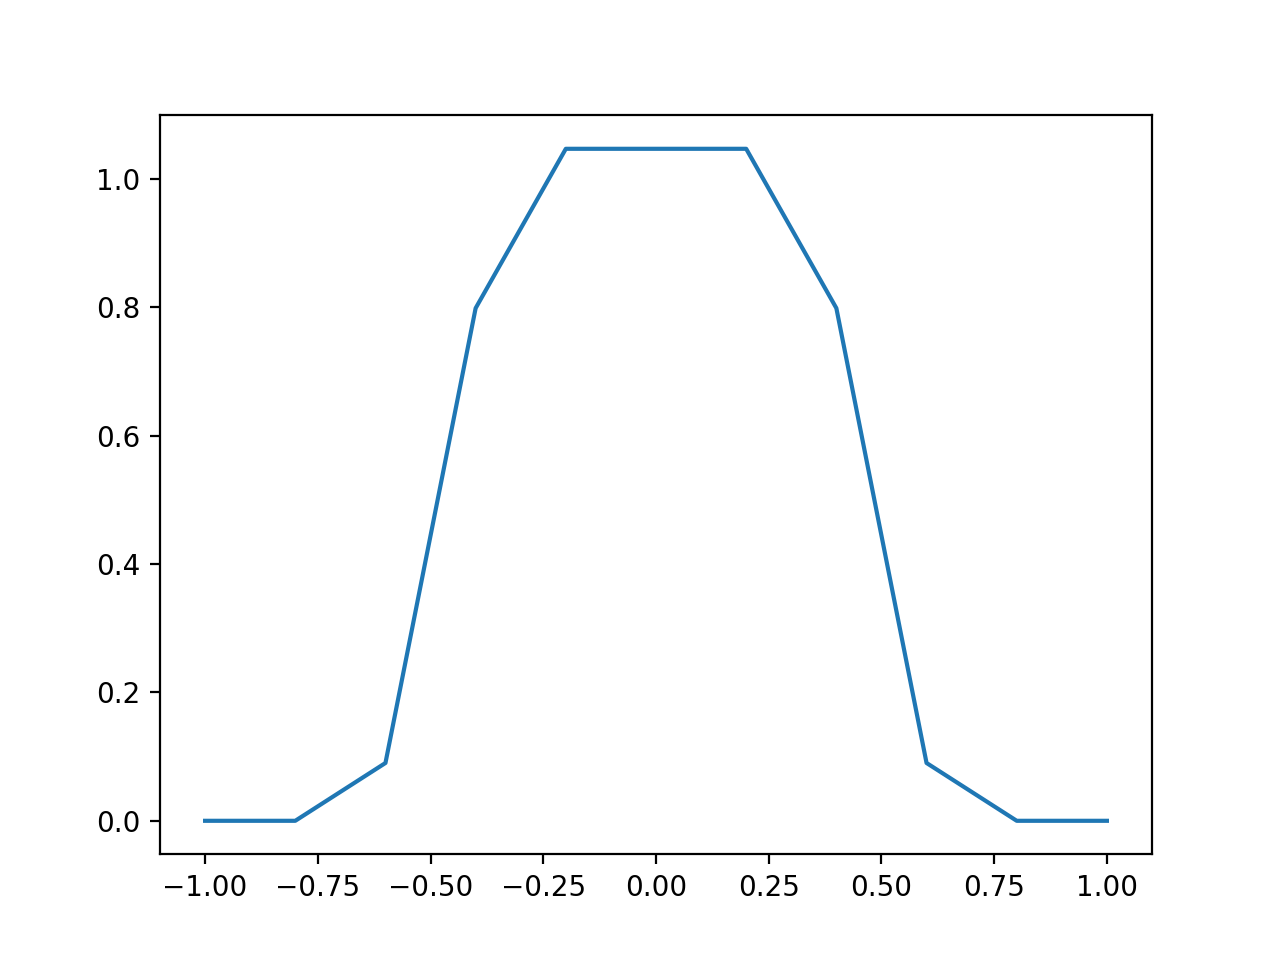

In [25]:
fig, ax = plt.subplots()
ax.plot(axis_t.centers, square_proj(np.pi+0.3, axis_t.centers));

In [26]:
def rect_conv_rect(x, a=1, b=1):
    assert a > 0
    assert b > 0
    return step1(x + 1/(2*a) + 1/(2*b)) - step1(x - 1/(2*a) + 1/(2*b)) - step1(x + 1/(2*a) - 1/(2*b)) + step1(x - 1/(2*a) - 1/(2*b))

<IPython.core.display.Javascript object>


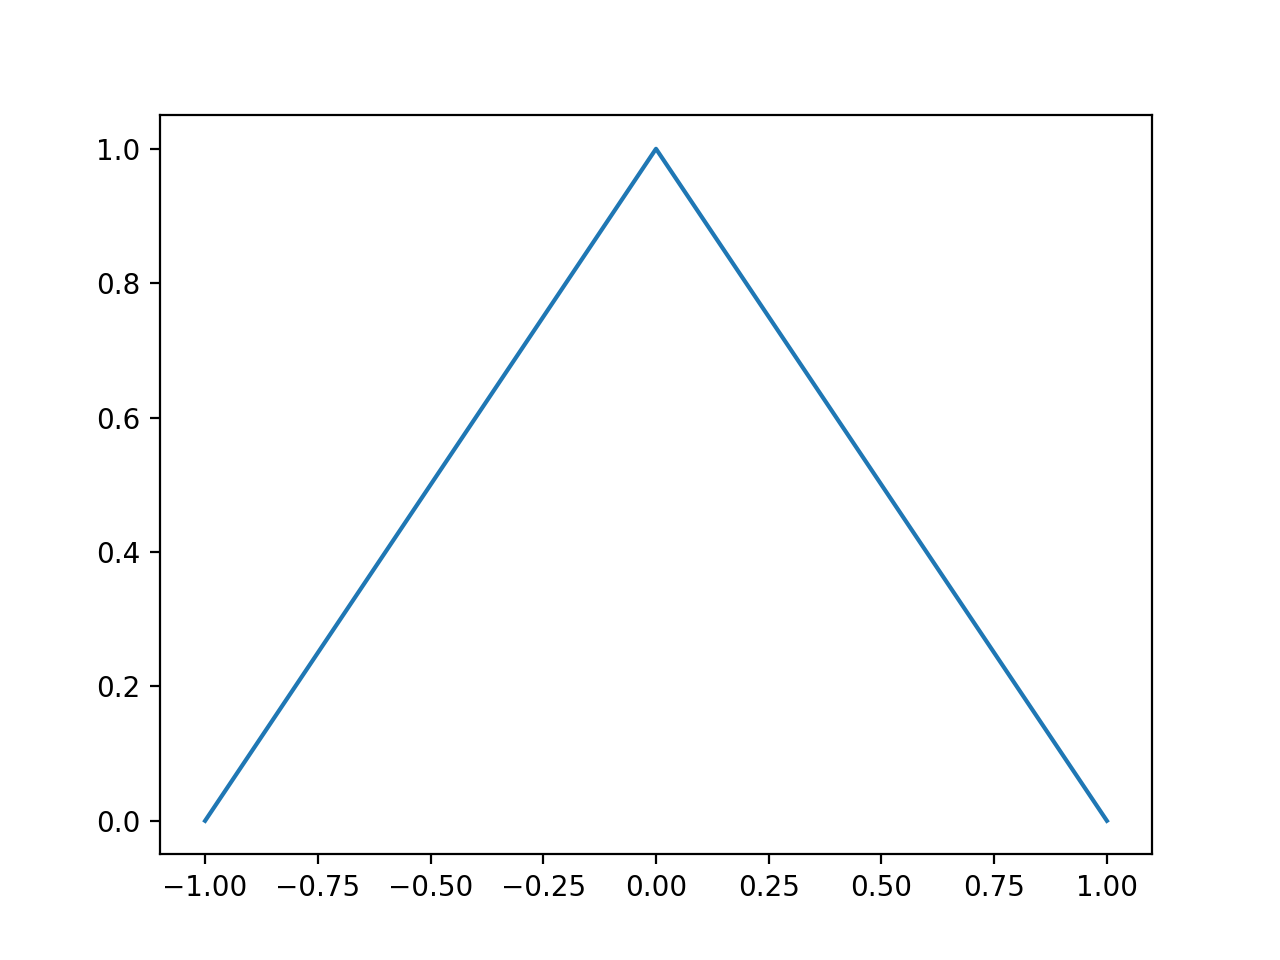

In [27]:
fig, ax = plt.subplots()
ax.plot(axis_t.centers, rect_conv_rect(axis_t.centers));

In [28]:
def square_proj_conv_rect(theta, r, a):
    assert a > 0
    theta = theta % (2*np.pi)
    if theta in [np.pi/4, 3*np.pi/4, 5*np.pi/4, 7*np.pi/4]:
        return np.sqrt(2) * a * rtri(r, a, 1/(np.sqrt(2)/2))
    elif np.abs(theta) in [0, np.pi/2, np.pi, 3*np.pi/2]:
        return a*rect_conv_rect(r, a=a)
    else:
        d_max = (np.abs(np.cos(theta)) + np.abs(np.sin(theta))) / 2
        d_break = np.abs(np.abs(np.cos(theta)) - np.abs(np.sin(theta))) / 2
        return 1/np.abs(np.cos(theta)*np.sin(theta)) * (d_max*a*rtri(r, a, 1/d_max) - d_break*a*rtri(r, a, 1/d_break))

<IPython.core.display.Javascript object>


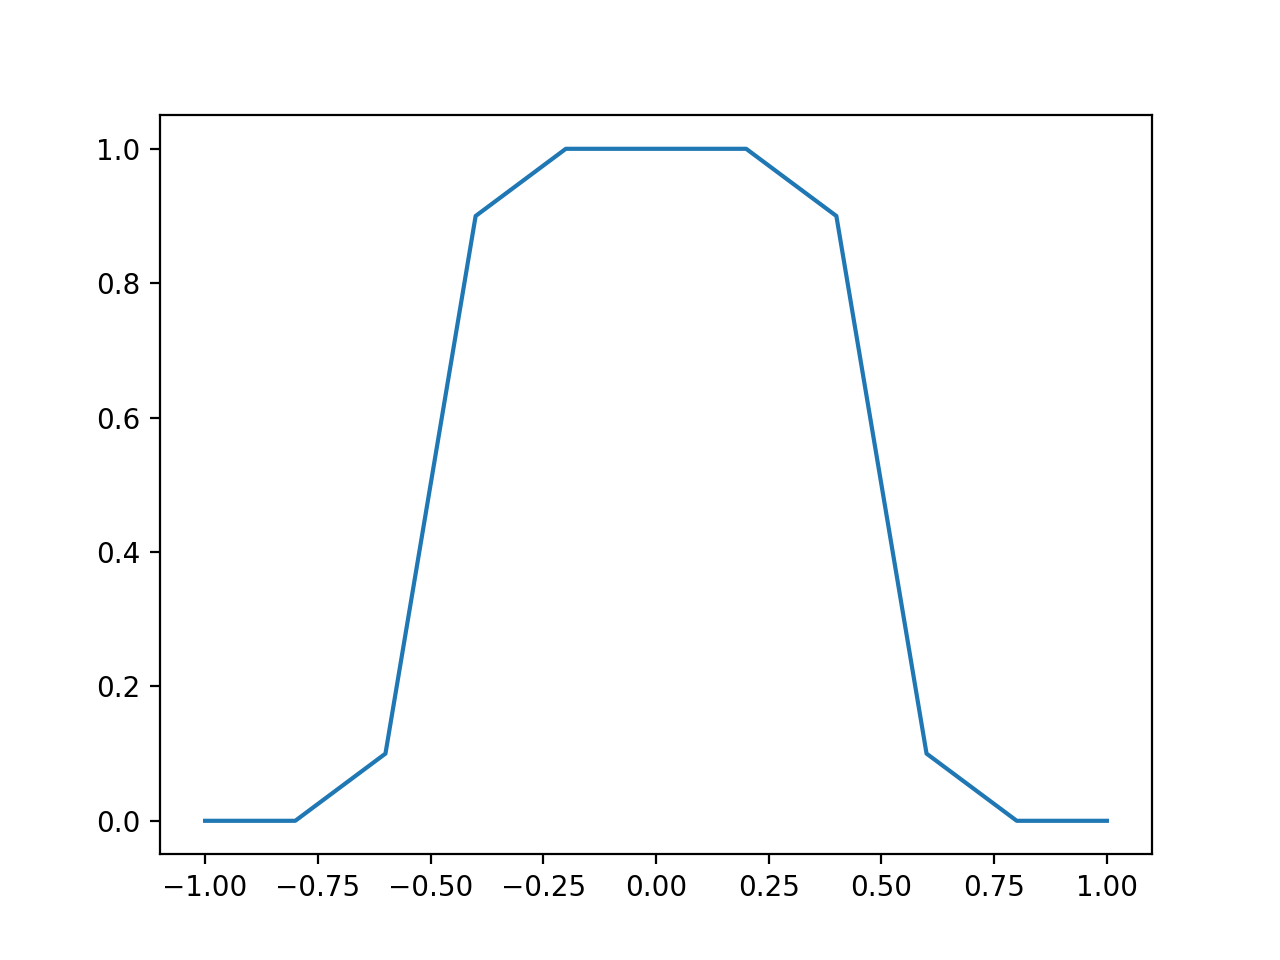

In [29]:
fig, ax = plt.subplots()
ax.plot(axis_t.centers, square_proj_conv_rect(0, axis_t.centers, 4));

<IPython.core.display.Javascript object>


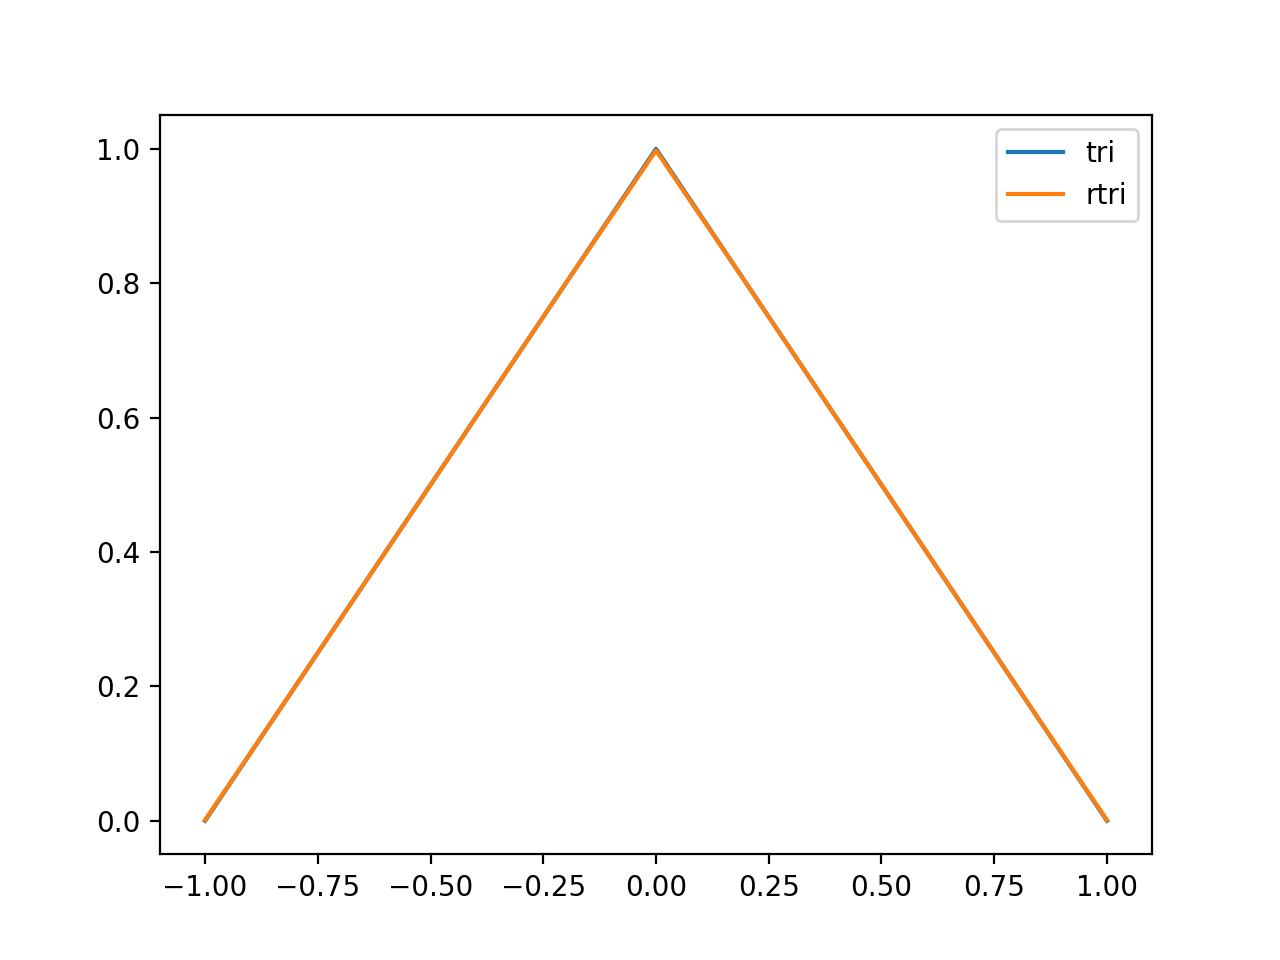

In [30]:
fig, ax = plt.subplots()
ax.plot(axis_t.centers, tri(axis_t.centers, 1), label='tri')
a = 100
ax.plot(axis_t.centers, a*rtri(axis_t.centers, a, 1), label='rtri')
plt.legend();

In [31]:
def angle_pi(a, b):
    if a * b > 0:
        return np.arctan(b / a)
    elif b == 0:
        return 0
    elif a == 0 and b != 0:
        return np.pi/2
    elif a * b < 0:
        return np.arctan(b / a) + np.pi
    else:
        assert False

In [32]:
def radon_affine_scale(theta, r, alpha, beta):
    theta_prime = angle_pi(beta*np.cos(theta), alpha*np.sin(theta))
    scale_factor = 1/np.hypot(beta*np.cos(theta), alpha*np.sin(theta))
    r_prime = r * np.abs(alpha) * beta * scale_factor
    return theta_prime, r_prime, scale_factor

In [33]:
H_beam = np.zeros((Np*Na, Nx*Ny))

In [34]:
Tx = grid.axis_x.T
Ty = grid.axis_y.T

theta_rad = np.radians(grid_y.axis_x)

assert Nx == Ny
a = Tx / grid_y.axis_y.T

alpha = 1 / Tx

# CHANGE --- BUILD CSR MATRIX
for i in tqdm(range(Ny)):
    for j in range(Nx):
        center_y, center_x = grid[i, j]
        for k, theta_k in enumerate(theta_rad):
            t_prime = grid_y.axis_y.centers - center_x * np.cos(theta_k) - center_y * np.sin(theta_k)
            #theta_prime, t_prime2, scale_factor = radon_affine_scale(theta_k, t_prime, 1/Tx, 1/Ty)
            #p_theta_k = scale_factor * square_proj_conv_rect(theta_prime, t_prime2, a) / a
            p_theta_k = square_proj_conv_rect(theta_k, alpha * t_prime, a) / a / alpha
            H_beam[range(k, Na*Np, Na), i*Nx + j] = p_theta_k

100%|█████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.48it/s]


<IPython.core.display.Javascript object>


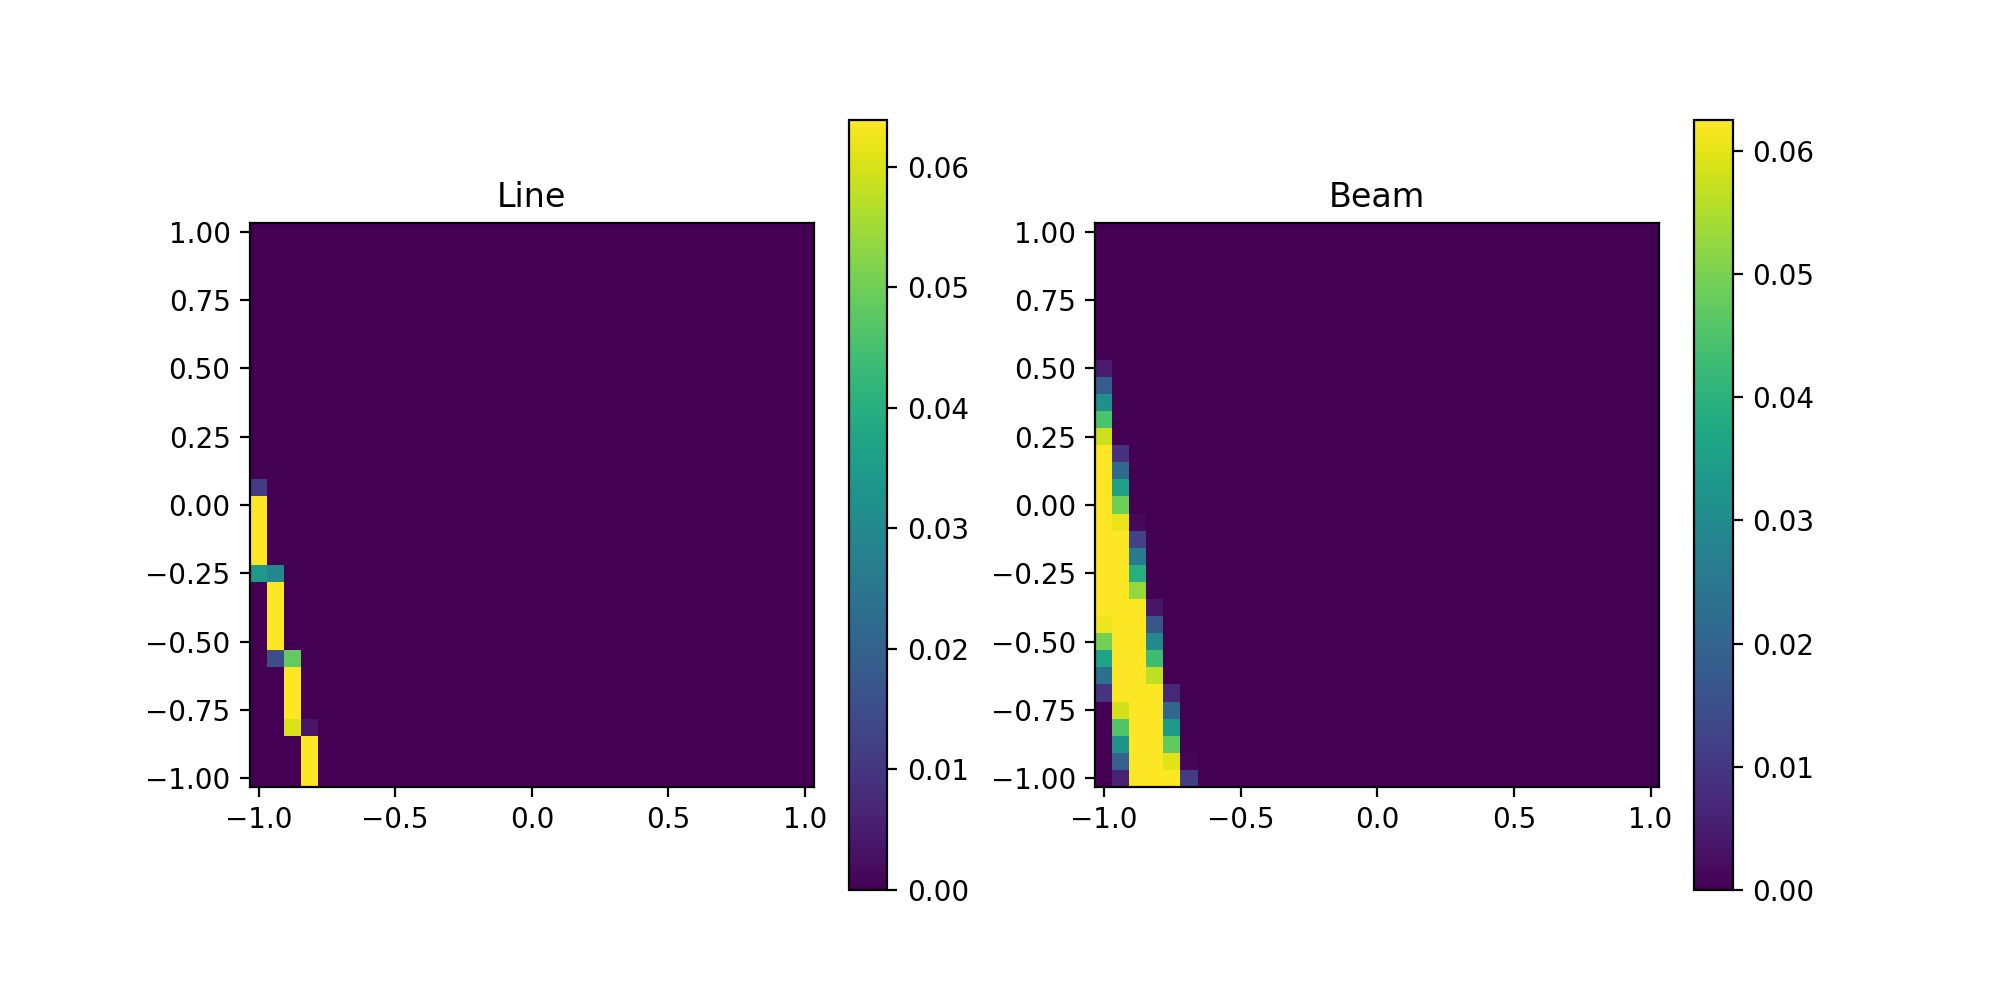

In [35]:
#index = 1000
index = 3

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
im0 = grid.plot(ax[0], H[index, :].reshape(Ny, Nx))
ax[0].set_title('Line')
fig.colorbar(im0, ax=ax[0])
im1 = grid.plot(ax[1], H_beam[index, :].reshape(Ny, Nx))
ax[1].set_title('Beam')
fig.colorbar(im1, ax=ax[1]);

In [36]:
y_rect = p.sinogram(grid_y, rect=True)

<IPython.core.display.Javascript object>


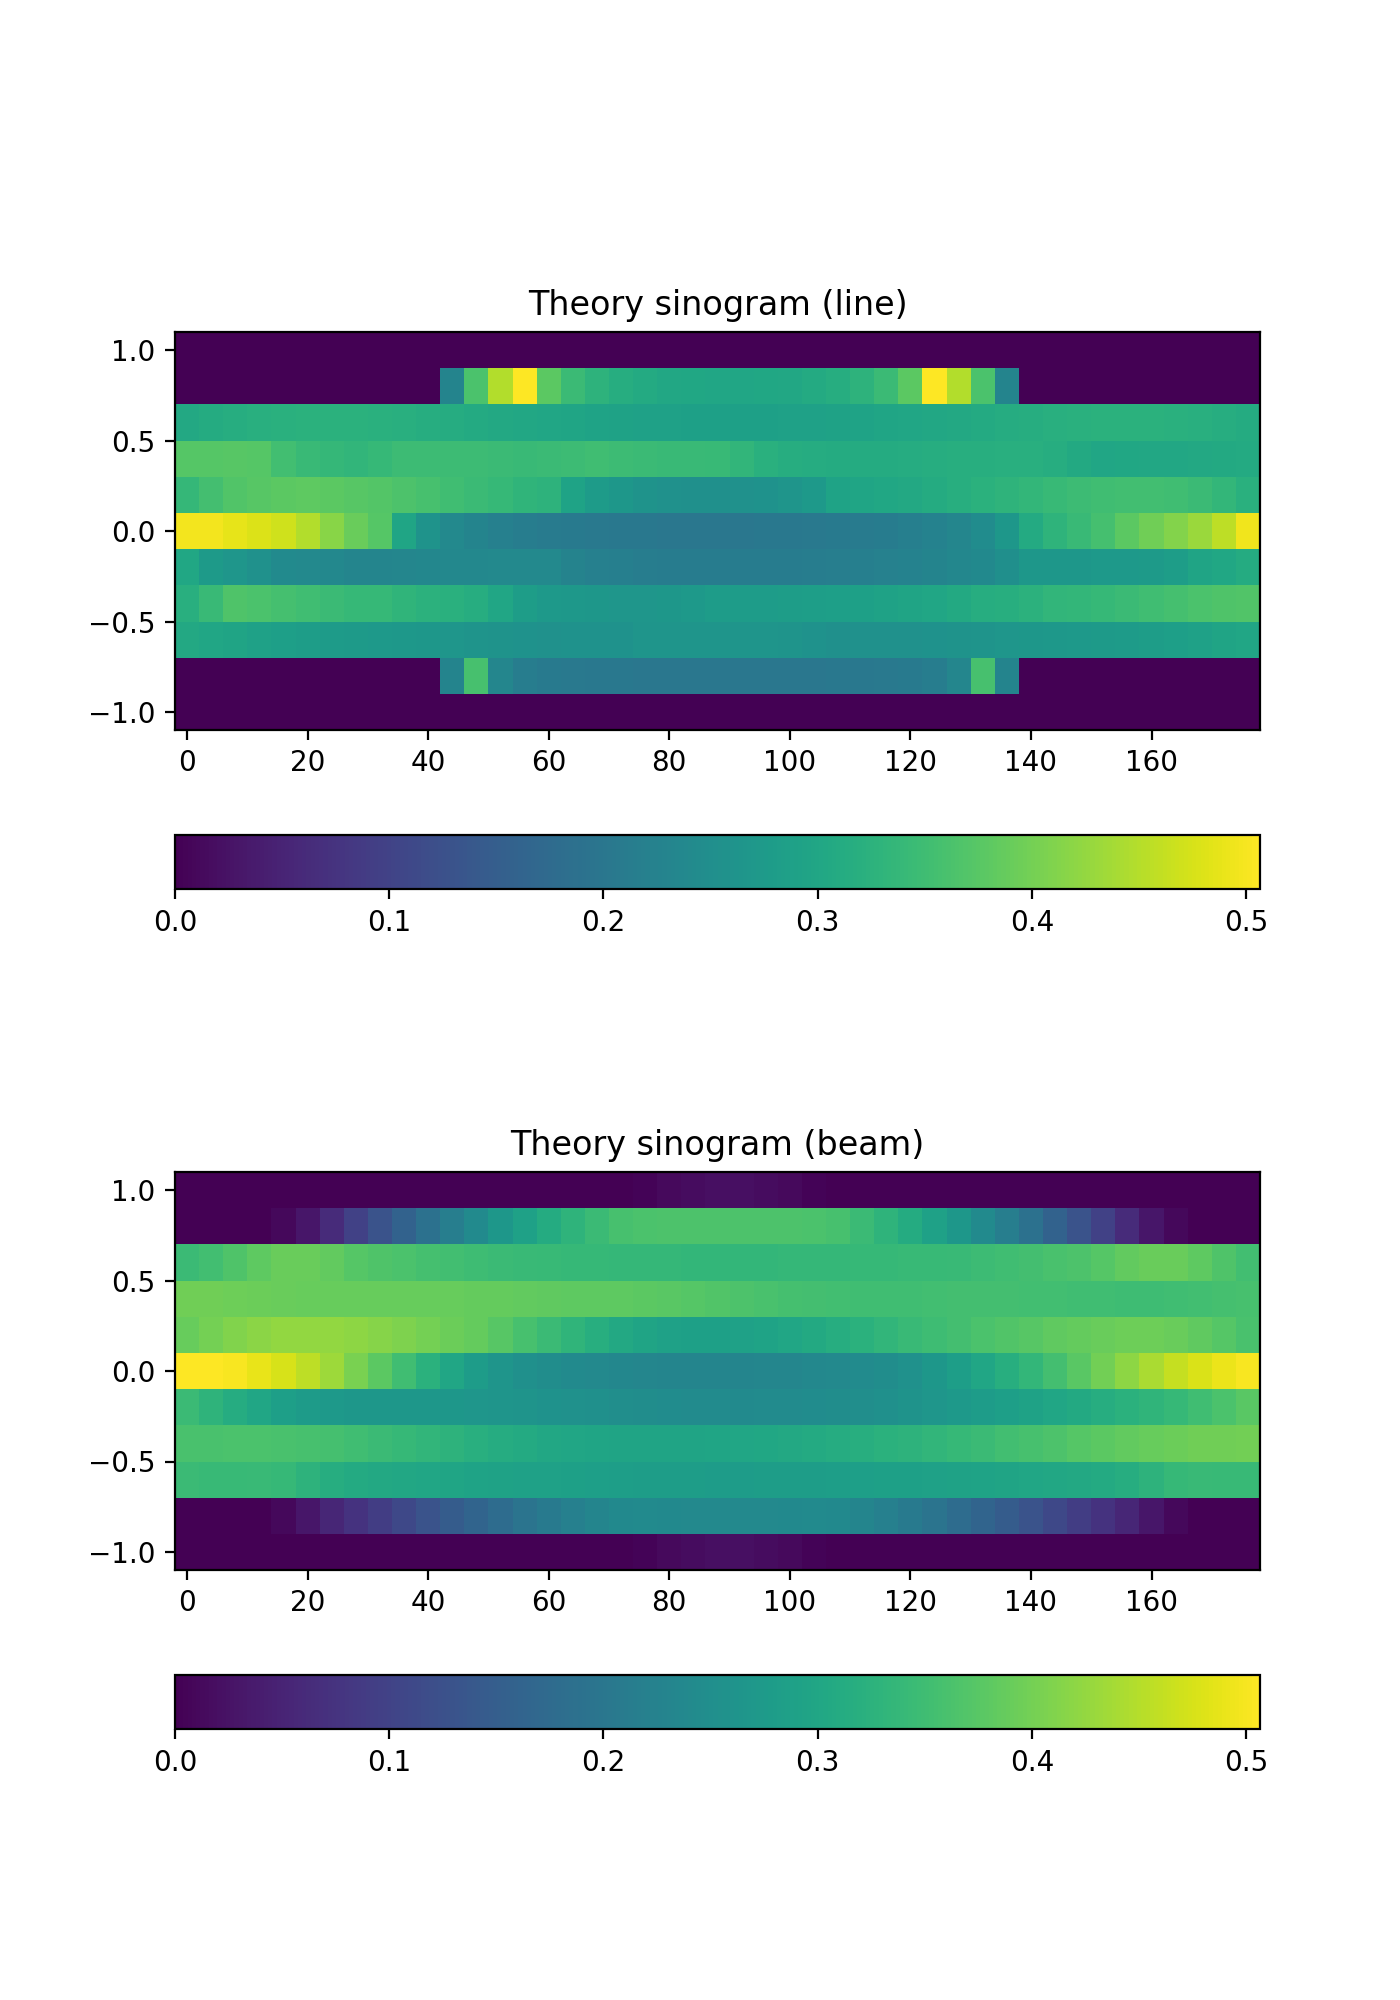

In [37]:
fig, ax = plt.subplots(nrows=2, figsize=(7, 10))
im0 = grid_y.plot(ax[0], y)
ax[0].set_aspect(30)
ax[0].set_title('Theory sinogram (line)')
fig.colorbar(im, ax=ax[0], orientation='horizontal')
im1 = grid_y.plot(ax[1], y_rect)
ax[1].set_aspect(30)
ax[1].set_title('Theory sinogram (beam)')
fig.colorbar(im, ax=ax[1], orientation='horizontal');

In [38]:
y_matrix_beam = H_beam @ x.flat
y_matrix_beam.shape = Np, Na

<IPython.core.display.Javascript object>


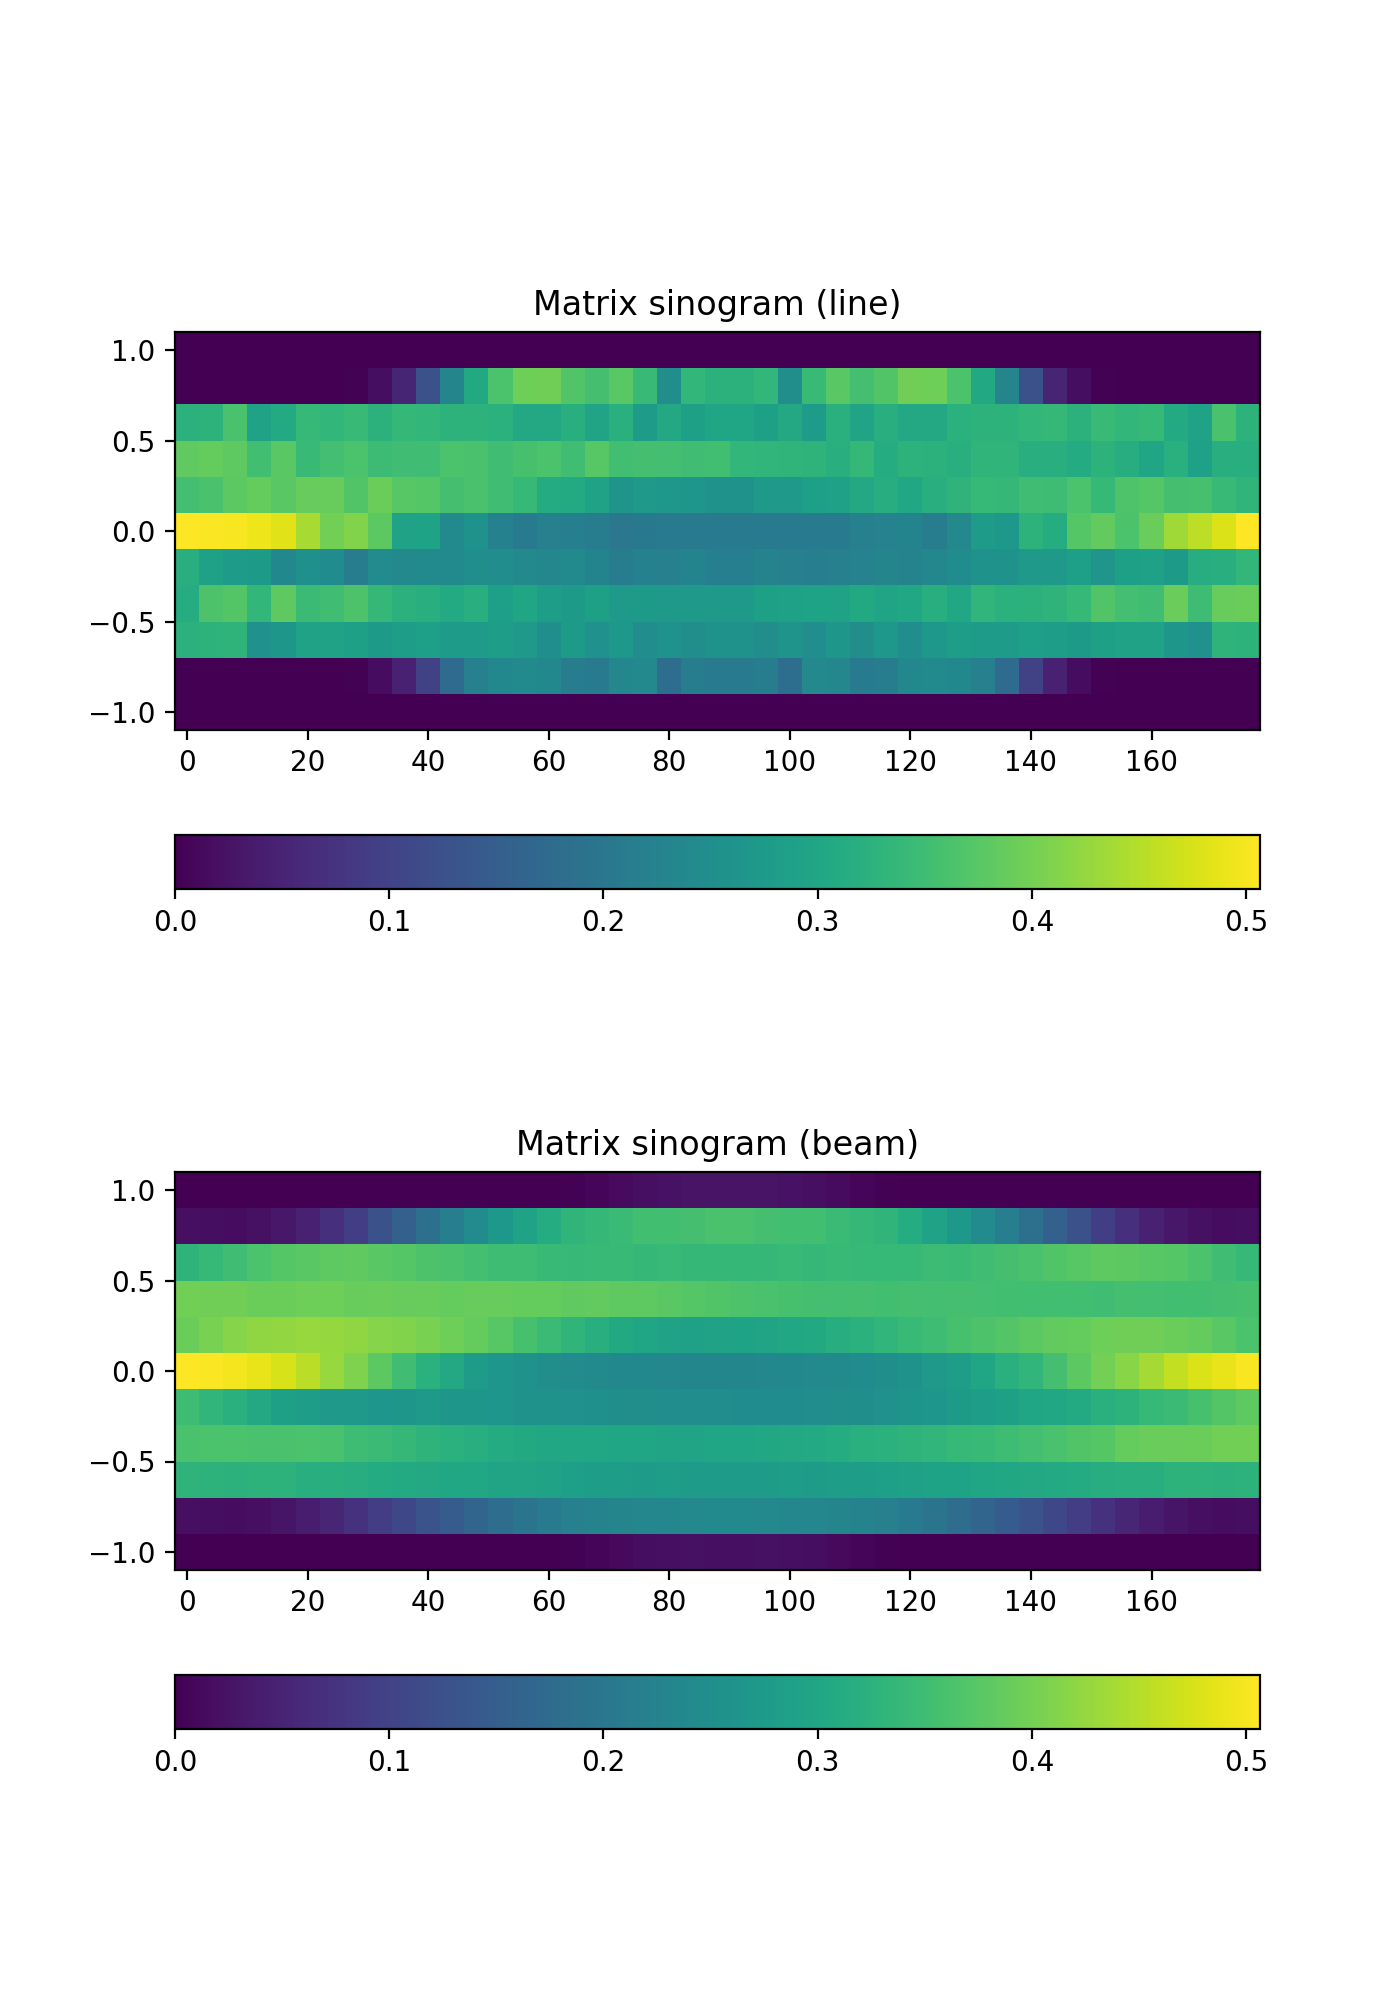

In [39]:
fig, ax = plt.subplots(nrows=2, figsize=(7, 10))
im0 = grid_y.plot(ax[0], y_matrix)
ax[0].set_aspect(30)
ax[0].set_title('Matrix sinogram (line)')
fig.colorbar(im, ax=ax[0], orientation='horizontal')
im1 = grid_y.plot(ax[1], y_matrix_beam)
ax[1].set_aspect(30)
ax[1].set_title('Matrix sinogram (beam)')
fig.colorbar(im, ax=ax[1], orientation='horizontal');